# Titanic: Prediction of Survivors

*Alex Philip Berger*

8/22/2019

## Intro

The purpose of this notebook is to demonstrate a **Data Science project** (import, transform, visualize, model, communicate) implemented in **Python** (as a Jupyter notebook). 

In the notebook I use *pandas*, *matplotlib*, *seaborn*, *scikit-learn*, and apply different machine learning algorithms (logistic regression, gaussian naive bayes, random forest, etc.) to a simple binary classification problem.

Specifically, I predict survivors from the Titanic accident (a classic introductory problem in Data Science).

---

*Data context (provided by Kaggle)*:

- On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated **32% survival rate**.
- One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

Read more here: https://www.kaggle.com/c/titanic.

## 1. Import libraries

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

## 2. Data

In this section, I import and learn about data.

### 2.1. Data Import

In [2]:
train_df = pd.read_csv('data/train.csv') # df
test_df = pd.read_csv('data/test.csv') # df
combine = [train_df, test_df] # list

### 2.2. Data Inspection

First, preview the data:

In [3]:
train_df.iloc[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Variable definitions are found on the Kaggle site: https://www.kaggle.com/c/titanic/data

Comment: Survived, Sex, Embarked are **categorical** variables. PClass is an **ordinal categorical** variables (ordered). SibSp and Parch are **continuous numerical** variables. Age and Fare are do **discrete numerical** variables. Ticket, Cabin and Name are **string** or **mixed** (string and numbers).

The response variable, Survived, is a discrete numerical, specifically, a binary.

The dimensions of the data set:

In [4]:
train_df.shape

(891, 12)

The python data types (commented out for brevity):

In [5]:
# train_df.info()
# print('*'*50)
# test_df.info()

### 2.3. Data Quality

I identify columns with missing values:

In [6]:
train_df.isna().sum() # training data

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
test_df.isna().sum() # test data

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

This will be addressed later on.

### 2.4. Data Representativeness & Distributions

Is the training dataset representative of the problem domain? 

I start with the **continuous variables**:

In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


For example:

1) Total sample: 891. Full data: 2224. This corresponds to 40 % of total data. OK.

2) Response distribution in sample: 38 %. Full data: 32 % (from Kaggle). OK

3) Variable distribution in sample, for Parch. In sample: 62 % (1-0.38) travelled without parents. In full data: 75 %. OK.

I could continue. For brevity, I conclude here that data is fairly representative.

I also look at **categorical variables**.

In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Bostandyeff, Mr. Guentcho",male,CA. 2343,G6,S
freq,1,577,7,4,644


I do not know about full sample distributions here. Still, I make a few observations:

- Sex take on the 'male' value in 65 % (577/891) of cases.
- Embarked: There are 3 possible end destinations. Most popular is S.
- Name: All names are unique (as: count = unique)
- Cabin: Has duplicates, as count(!= unique).
- Ticket: Has duplicates, as (count != unique).

### 2.5 Test hypotheses - Pivots

From the problem description (also repeated in the introduction section above), we have the following assumptions: 
- Women were more likely to survive. 
- Upperclass passengers (Pclass=1) were more likely to survive.
- Children were more likely to survive.

I confirm these (in order) through the following 3 pivots:

In [10]:
(train_df[['Survived', 'Sex']].
    groupby(['Sex']).
    mean().
    sort_values(by='Survived', ascending=False))

,Survived
Sex,
female,0.742038
male,0.188908


In [11]:
(train_df[['Survived', 'Pclass']].
     groupby(['Pclass']).
     mean().
     sort_values(by='Survived', ascending=False)
)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [12]:
train_df['Child'] = np.where(train_df['Age']<18, 1, 0) # I define children as being less than 18 years old.

print(
  train_df[['Survived', 'Child']].
     groupby(['Child']).
     mean().
     sort_values(by='Survived', ascending=False)
)

train_df = train_df.drop(['Child'], axis = 1);

       Survived
Child          
1      0.539823
0      0.361183


### 2.5 Response vs Continuous Features

**Age** (continuous): 

I first go further into the relation between Age and Survival. A histogram is a natural choice for continuous variables.

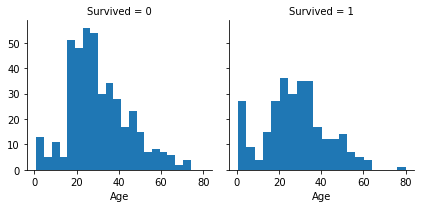

In [13]:
g = sns.FacetGrid(train_df, col='Survived') 
g.map(plt.hist, 'Age', bins=20)

I observe:
- The oldest passenger survived (age 80) 
- Infants (the 'bucket' furthest to the left) has a high survival rate
- Most passengers are in the 15-35 range.

Conclusion: Age is an important predictor of survival. It should be considered for model training, and NAs imputed. Also, age groups are relevant.

**Age *and* Pclass** (continuous and categorical)

I split the above plot further, by PClass, thus creating 6 histograms:

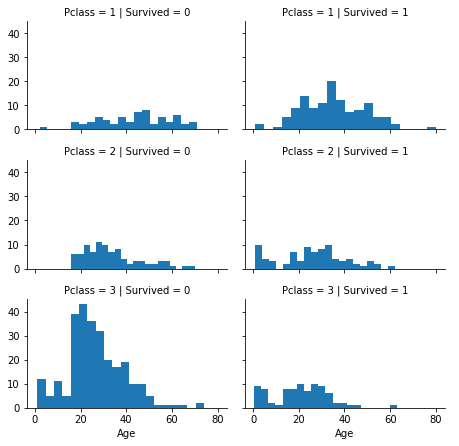

In [14]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.1, aspect=1.5)
grid.map(plt.hist, 'Age', alpha=1, bins=20)
grid.add_legend();

I observe:
- Pclass 3 had most passengers - and most did not survive.
- Infant passengers in Pclass 1 and 2 mostly survived.
- Only in Pclass 1 did most people survive. 

Conclusion: PClass should be considered for model training.

### 2.6 Response vs Categorical Features

**Pclass and Embarked** (Categorical and categorical)

Pointplot:

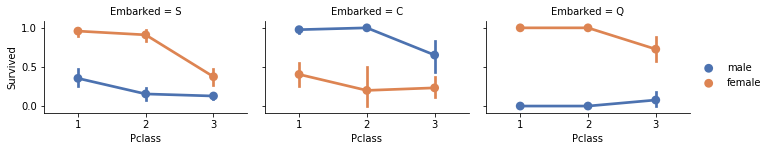

In [15]:
grid = sns.FacetGrid(train_df, col = 'Embarked', height=2.2, aspect=1.5)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=None, hue_order=None)
grid.add_legend()

I observe:
- female has higher survival rates for destination S and Q, but not for C. Some correlation might be going in the latter case.
- Pclass 1 is generally better than Pclass 2 and 3 respectively.

Conclusion: Sex should be considered for model training. Embarkation, too - and this one should also be imputed for NAs.

**Embarked, Sex, and Fare** (Categorical, categorical, continuous)

Barplot:

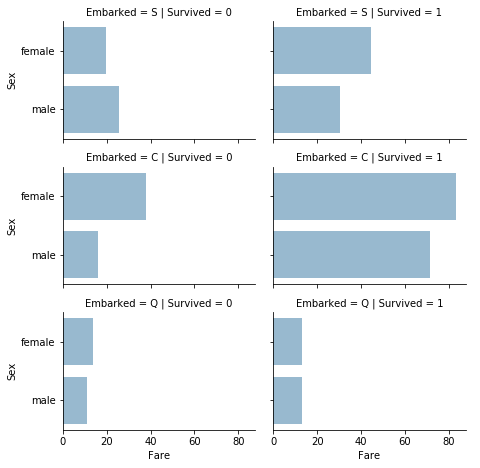

In [16]:
grid = sns.FacetGrid(train_df, row = 'Embarked', col = 'Survived', height=2.2, aspect=1.5)
grid.map(sns.barplot, 'Fare', 'Sex', ci=None, alpha=.5, order=None, hue_order=None)
grid.add_legend()

I observe:
- Fare does not seem to matter in most groupings.

Conclusion: Consider dropping Fare.

### 2.7 Data wrangle 

I this section, I *wrangle* data: I drop, create, and transform features.

**Drop features**

First, I drop features. Specifically, 'Ticket' and 'Cabin' both have many duplicates. Further, they are unlikely to correlate well with survival. Also, 'PassengerId' contains no predictive value, intuitively. However, I only remove the 'PassengerId' from the training data (as it is needed as an identifier in the test data).

In [17]:
print("Before dropping:", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape) # data dimensions before dropping

train_df = train_df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After dropping:", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape) # data dimensions after dropping

Before dropping: (891, 12) (418, 11) (891, 13) (418, 11)
After dropping: (891, 9) (418, 9) (891, 9) (418, 9)


**Feature extraction**

I investigate if I can extract titles from 'Name', and if it correlates with survival.

In [18]:
# Build 'Title' feature:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' (\w+\.)', expand=False) # (\w+\.) match first word ending with a dot
    dataset['Title'] = dataset['Title'].str[:-1]
# The above has modified the objects that 'combine' points to:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [19]:
pd.crosstab(train_df['Sex'], train_df['Title']) # Count titles across gender

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [20]:
# I modify the new variable: (1) I classify rare titles as 'Rare'. (2) I fix assumed misspellings
rare_titles = ['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir']
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(rare_titles, 'Rare') # (1)
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') # (2)
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss') # (2)
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') # (2)

# View correlation between Title and Survival
train_df[['Title', 'Survived']].groupby('Title').mean().sort_values(by='Survived', ascending=False)

,Survived
Title,
Mrs,0.793651
Miss,0.702703
Master,0.575000
Rare,0.347826
Mr,0.156673


Title indeed looks to like a relevant feature. I continue to convert from *categorical titles* to *ordinal*: 

In [21]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0) # NA Handling¨
    
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


**Drop features**

I can now drop Name, as I have extracted all relevant information from the column.

In [22]:
train_df = train_df.drop(['Name'], axis = 1)
test_df = test_df.drop(['Name'], axis = 1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

**Transform Feature: Categorical to Ordinal**

Most model algorithms work with numerical values. Thus, categorical values must be transformed.

For variable *Sex*, it looks like this:

In [23]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

In [24]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


**Transform Feature: Impute NAs (numerical variable)**

I now impute NA's for Age (177 values in total, shown above).

Specifically, I impute with the median value of Age across Sex and Pclass groups (and per data set), using a for loop:

In [25]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna() # group age values
            age_guess = guess_df.median()
            age_guess_rounded = int(age_guess/0.5 + 0.5) * 0.5 # group median rounded to nearest .5 age
            dataset.loc[(dataset.Age.isnull()) & 
                        (dataset.Sex == i) & 
                        (dataset.Pclass == j+1), 'Age'] = age_guess_rounded # assign rounded group median
            
    dataset['Age'] = dataset['Age'].astype(int)  
    
train_df.Age.isna().sum() # Problem solved!

0

**Transform Feature: Create categories from a continuous variable**

Now, I split Age into 'Age bands', and show that a correlation to 'Survived' is present:

In [26]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5) # create 5 groups
train_df[['AgeBand', 'Survived']].groupby(['AgeBand']).mean().sort_values(by='Survived', ascending=True)

,Survived
AgeBand,
"(64.0, 80.0]",0.090909
"(16.0, 32.0]",0.337374
"(32.0, 48.0]",0.412037
"(48.0, 64.0]",0.434783
"(-0.08, 16.0]",0.550000


I replace 'Age' with the categories displayed above:

In [27]:
def age_categories(x):
    if(x <= 16):
        return 0
    elif(x < 32):
        return 1
    elif(x < 48):
        return 2
    elif(x < 64):
        return 3
    else:
        return 4
    
for dataset in combine:
    dataset['Age'] = dataset['Age'].apply(lambda x: age_categories(x)).astype(int)

Now I can remove 'AgeBand':

In [28]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


**Feature Creation**

I build a feature, FamilySize, by adding Parch and SibSp, and show that it works as a predictor:

In [29]:
for dataset in combine:
    dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize']).mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


**Feature Creation**

I build a feature, isAlone, and show that it works as a predictor:

In [30]:
for dataset in combine:
    dataset['isAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'isAlone'] = 1
    
train_df[['isAlone', 'Survived']].groupby(['isAlone']).mean()

,Survived
isAlone,
0,0.505650
1,0.303538


You are more likely to *not survive* if you are alone.

**Drop features**

I drop Parch, SibSp, and FamilySize, as I choose to go with 'isAlone'.

In [31]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

**Feature Creation**

I combine Pclass and Age into *one* feature:

In [32]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


**Transform Features: Impute NAs (categorical)**

Embark has 2 missing values in the training data set, and I replace these with the most occuring value.

In [33]:
most_frequent_emb = train_df.Embarked.dropna().mode()[0]

In [34]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(most_frequent_emb)
    
dataset.Embarked.isna().sum()

0

I then map into a numeric Port feature:

In [35]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


**Transform Features: Impute NAs (numerical)**

I replace NA's in Fare with the median value:

In [36]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

Now the problem of missing values is solved:

In [37]:
test_df.isna().sum().sum() + train_df.isna().sum().sum()

0

In [38]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


**Transform Features: Create categories from a continuous variable**

As with 'Age', I convert 'Fare' into ordinal values:

In [39]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
(train_df[['FareBand', 'Survived']].
    groupby(['FareBand'], as_index=False).
    mean().
    sort_values(by='FareBand', ascending=True))

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [40]:
def fare_categories(x):
    if(x <= 7.910):
        return 0
    elif(x < 14.454):
        return 1
    elif(x < 31.000):
        return 2
    else:
        return 3
    
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].apply(lambda x: age_categories(x)).astype(int)
    
train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

**Data Wrangling Result**

After Data Wrangling, data looks like this:

In [41]:
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,4,1,3,0,2
2,1,3,1,1,0,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,0,0,1,1,6
5,0,3,0,1,0,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,1,0,4,0,0
8,1,3,1,1,0,0,3,0,3
9,1,2,1,0,1,1,3,0,0


In [42]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,892,3,0,2,0,2,1.0,1,6
1,893,3,1,2,0,0,3.0,0,6
2,894,2,0,3,0,2,1.0,1,6
3,895,3,0,1,0,0,1.0,1,3
4,896,3,1,1,0,0,3.0,0,3
5,897,3,0,0,0,0,1.0,1,0
6,898,3,1,1,0,2,2.0,1,3
7,899,2,0,1,1,0,1.0,0,2
8,900,3,1,1,0,1,3.0,1,3
9,901,3,0,1,1,0,1.0,0,3


Data only contains numeric values. NA's + missing data are cleaned up. Thus, we are ready to start modelling.

## 4. Model

First, I split train_df into *X* (input) and *Y* (response) data frames. I also create a similar *X* data frame for test_df.

In [43]:
X_train = train_df.drop("Survived", axis = 1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis = 1).copy()
X_train.shape, Y_train.shape, X_test.shape 

((891, 8), (891,), (418, 8))

In [44]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,isAlone,Age*Class
0,3,0,1,0,0,1,0,3
1,1,1,2,4,1,3,0,2
2,3,1,1,0,0,2,1,3
3,1,1,2,3,0,3,0,2
4,3,0,2,0,0,1,1,6


Now, I go through a series of relevant models for this **Supervised Binary Classification Problem**.:

#### 4.1 Logistic Regression 

Logistic Regression is a type of Generalized Linear Model (GLM) that uses a logistic function to model a binary variable based on all kinds of independent variables.

Setting up a model is simple:

In [45]:
logreg = LogisticRegression(solver='lbfgs') # Create Logistic Regression Object 
logreg.fit(X_train, Y_train)  # Fit model on training data
Y_pred = logreg.predict(X_test) # Apply model (binary classifier) on test data
Y_pred[:15]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1])

In [46]:
acc_log = round(logreg.score(X_train, Y_train) * 100, 2) # Determine mean prediction accuracy
acc_log

80.81

I can further analyse how the variables correlate to survival, and by how much:

In [47]:
coeff_df = pd.DataFrame(train_df.columns.delete(0)) # Create data frame with column names as rows
coeff_df.columns = ['Feature'] # Set column name
coeff_df["Correlation"] = pd.Series(logreg.coef_[0]) # Calculate coefficient of features
coeff_df.sort_values(by='Correlation', ascending = False)

,Feature,Correlation
1,Sex,2.178245
5,Title,0.403098
4,Embarked,0.289638
6,isAlone,0.234783
3,Fare,0.011646
7,Age*Class,-0.005944
2,Age,-0.441685
0,Pclass,-1.140772


I see:
- 'Sex' increases the probability of survival (Survived = 1) the most. Specifically, Sex = 1 (woman). 
- Pclass decreases probability of survival the most.
- I can analyse each variable to get a feel of their importance.


##### 4.2 Support Vector Machines

Support Vector Machines (SVMs) are a type of classification algorithm that are more flexible - they can do linear classification, but can use other non-linear basis functions. 

I set up the model:

In [48]:
svc = SVC(gamma = 'scale')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

82.49

I note that accuracy is higher for SVM than Logistic Regression.

#### 4.3 k-Nearest Neighbors (k-NN)

In the k-Nearest Neighbors algorithm (k-NN), a sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small).

In [49]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

83.84

k-Nearest Neighbors performs better tha SVM. 

So far, the model performance hierarchy is: k-NN > SVM > Logistic Regression.

#### 4.4 Gaussian Naive Bayes

The Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features.

In [50]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

76.43

Now: k-NN > SVM > Logistic Regression > Gaussian Naive Bayes.

Speeding up a bit:

#### 4.5 Perceptron

In [51]:
perceptron = Perceptron(tol = 0.19)
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.69

#### 4.6 Linear SVC

In [52]:
linear_svc = LinearSVC(max_iter = 10000)
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.35

#### 4.7 Stochastic Gradient Descent

In [53]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


78.0

#### 4.8 Decision Tree

In [54]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.31

#### 4.9 Random Forest

Now, the popular Random Forest algorithm, which is an ensemble method base on Decision Trees.

In [55]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.31

#### 4.10 XG Boost

Here, I try another ensemble method: The Gradient Boosting Machine (XG Boost)

In [56]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
Y_pred = xgb.predict(X_test)
xgb.score(X_train, Y_train)
acc_xgb = round(xgb.score(X_train, Y_train) * 100, 2)
acc_xgb

84.74

#### 4.11 Recap / Model evaluation

I now rank the evaluation of all the models.,

In [57]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'XGBoost'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_xgb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.31
8,Decision Tree,86.31
9,XGBoost,84.74
1,KNN,83.84
0,Support Vector Machines,82.49
2,Logistic Regression,80.81
5,Perceptron,79.69
7,Linear SVC,79.35
6,Stochastic Gradient Decent,78.00
4,Naive Bayes,76.43


I choose the 'Random Forest' model - in terms of performance it ties with the 'Decision Tree' method, but it is generally less prone to overfit.

I chose not to tune any models - rather I showed a simple implementation of multiple models.

## 5. Final Results

The only thing left is to export a csv with the chosen predictions:

In [58]:
to_kaggle = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": Y_pred
})

to_kaggle.iloc[:10]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [59]:
to_kaggle.to_csv('output/submission.csv', index = False)